In [1]:
import numpy as np
import pandas as pd
import sklearn
import streamlit as st
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from scipy.sparse.linalg import svds


In [5]:
pd.read_csv('bagofWord.csv').dropna()

,name,bag_of_words
0,10 Barrel Brewing Portland,dish flavor shop meat food service sweet beer ...
1,108 Bar N Grill,dish flavor shop meat food service bubble tea ...
2,10th Avenue Liquor Store,dish flavor salad meat food service saladbeer ...
3,11th Avenue Liquor,dish flavor tobacco shops meat food service sa...
4,13 Virtues Brewing,dish flavor shop meat salad food service sweet...
...,...,...
3405,kBap,food service great ask peoplerestaurants peopl...
3406,krazy cups and cafe,food service ask great definitelydesserts tabl...
3407,red e café,flavor dish shop meat food service sweet great...
3408,show bar,burgers dish flavor meat food service great as...


In [4]:
with pd.read_csv('cf_preds_df.csv', chunksize=10**6) as reader:
    for chunk in reader:
        print(chunk)

MemoryError: 

In [ ]:
import os

os.environ["MODIN_ENGINE"] = "dask"
import modin.pandas as pd

In [3]:
toronto_URL= "toronto_data2.csv"
def load_data(url):
    data = pd.read_csv(url)
    return data

toronto_data = load_data(toronto_URL)

def score(data):
    # Computing Super-Score Rating for Reviews
    data['super_score'] = data['polarity'] *  data['compound']
    data['super_score'] = data['super_score'] + data['stars']

    return data
def cos_matrix(data):
    # Combining the text in Keywords and categories columns
    # data['All_Keywords'] = data['categories'].str.cat(data['Keywords'],sep=", ")
    
#####################################################################################################
#Optimizeeeeeeeeeeeeeeeee
    #### Delete not needed
    data['name']=data['name'].astype('string')
    data['super_score']=data['super_score'].astype('float32')
    data.drop(['Unnamed: 0','business_id','Keywords','categories'],axis=1,inplace=True)
    
    
    data['user_id']=data['user_id'].sort_values()
    
    
    #Attribute for making dataframe function(1)
    columns=data['name'].unique()
#####################################################################################################
    data=data.pivot_table(index = 'user_id', columns = 'name', values = 'super_score')
    data=data.fillna(0)
    #Attribute for making dataframe function(2)
    user_ids=list(data.index)
    
    
    
    
#Data numpy()
    
    data=data.to_numpy()
    
    #Mean
    data=(data.T - data.mean(axis = 1)).T
    
    
# SVD
    U, sigma, Vt = svds(data, k = 15)
    sigma = np.diag(sigma)
    
    # Overview of user ratings across all Restaurants in Toronto
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

#Output
    # Converting the reconstructed matrix back to a Pandas dataframe
    cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = columns, index=user_ids).transpose()

    return cf_preds_df

def item_matrix(cf_preds_df):
    # Creating Item-Item Matrix based on Cosine Similarity
    item_item_matrix = cosine_similarity(cf_preds_df)
    item_item_matrix= pd.DataFrame(item_item_matrix, columns=cf_preds_df.index, index = cf_preds_df.index)

    return item_item_matrix


# Creating Collaborative Filtering Function for Restaurant-Restaurant Recommendation System
def cf_recommender(restaurant):
    
    """Getting the correlation of a specific restaurant with other Toronto Restaurants"""
    restaurant_ratings = cf_preds_df.T[restaurant]
    similar_restaurant_ratings = cf_preds_df.T.corrwith(restaurant_ratings)
    corr_ratings = pd.DataFrame(similar_restaurant_ratings, columns=['Correlation'])
    corr_ratings.dropna(inplace=True)
    
    """Retrieving the Ratings Scores from the Item-Item Matrix"""
    ratings_sim = item_item_matrix[restaurant]
    
    """Filtering for positively correlated restaurants"""
    ratings_sim = ratings_sim[ratings_sim>0]
    
    """Generate Top 10 Recommended Restaurants"""
    """Exclude top row as that will be the same restaurant"""
    return ratings_sim.sort_values(ascending= False).head(11)[1:]

cf_preds_df=cos_matrix(toronto_data)
item_item_matrix=item_matrix(cf_preds_df)
cf_recommender('DITTO')

Pedacito de Mexico               0.973263
Smaaken Waffle Sandwiches        0.946709
Milo's City Cafe                 0.946552
The Clubhouse Bar & Grill        0.943635
Marthas                          0.942306
Portland Curry Company           0.941346
Ding Tea Williams                0.940772
Al Mustafah                      0.938645
Spunky Monkey Coffee Roasters    0.936254
Cartlandia - Food Carts          0.935791
Name: DITTO, dtype: float32

In [13]:
import sys
print(sys.getsizeof(test))

2259435910


In [3]:
toronto_data['user_id']=toronto_data['user_id'].sort_values()

In [12]:
test=cos_matrix(toronto_data)

In [14]:
def item_matrix(cf_preds_df):
    # Creating Item-Item Matrix based on Cosine Similarity
    item_item_matrix = cosine_similarity(cf_preds_df)
    item_item_matrix= pd.DataFrame(item_item_matrix, columns=cf_preds_df.index, index = cf_preds_df.index)

    return item_item_matrix
matrix=item_matrix(test)

In [24]:
toronto_data

,Unnamed: 0,business_id,user_id,super_score,Keywords,name,categories
0,0,9P-lp3AWDXGayDqJz9VPwQ,u2xPfv6_wcKt-lW-C1cV8A,2.359240,"place, food, great, love, service, really, wel...",Marukin Ramen,"Restaurants, Ramen, Noodles, Japanese"
1,1,9P-lp3AWDXGayDqJz9VPwQ,-Yz0xKcvc8N1csjA0dQkyQ,4.138614,"order, chicken, fry, sauce, taste, dish, flavo...",Marukin Ramen,"Restaurants, Ramen, Noodles, Japanese"
2,2,9P-lp3AWDXGayDqJz9VPwQ,F6lpBpTVt3QExHd4keHWlw,3.423177,"place, food, great, love, service, really, wel...",Marukin Ramen,"Restaurants, Ramen, Noodles, Japanese"
3,3,9P-lp3AWDXGayDqJz9VPwQ,7DEs7-EpMm9xmpmaYKDkGw,3.155376,"order, time, wait, food, give, table, ask, nev...",Marukin Ramen,"Restaurants, Ramen, Noodles, Japanese"
4,4,9P-lp3AWDXGayDqJz9VPwQ,2iRzv3CriSqvM8b1WntnUQ,5.176691,"place, food, great, love, service, really, wel...",Marukin Ramen,"Restaurants, Ramen, Noodles, Japanese"
...,...,...,...,...,...,...,...
411419,411419,WamRRiJi0x_cKrZ_68zjqg,XKgIVMdQ0843XRGf5f-f9w,5.269867,"place, food, great, love, service, really, wel...",Lux Pizza Parlor,"Food, Restaurants, Food Trucks, Pizza"
411420,411420,Qya_E-sMHDv9UqiB9TwISQ,bN2cj127F3Duf6W3lOu7xQ,5.219076,"order, time, wait, food, give, table, ask, nev...",Simmer Down Catering,"Educational Services, Personal Chefs, Wedding ..."
411421,411421,Qya_E-sMHDv9UqiB9TwISQ,cO3MlvEnctE7topt0ytksg,5.282853,"order, chicken, fry, sauce, taste, dish, flavo...",Simmer Down Catering,"Educational Services, Personal Chefs, Wedding ..."
411422,411422,zU1vXkdMFbhtmCIF59TEaw,G5XDLQaaBWlt2c0YkDt0Yw,5.096289,"order, time, wait, food, give, table, ask, nev...","Heavens Tea, School of Tea Arts","Specialty Schools, Tea Rooms, Education, Food"


In [4]:
 #### Delete not needed
data=toronto_data.copy()
data['user_id']=data['user_id'].astype('string')
data['name']=data['name'].astype('string')
data['super_score']=data['super_score'].astype('float32')
data.drop(['Unnamed: 0','business_id','Keywords','categories'],axis=1,inplace=True)

In [5]:
data=data.pivot_table(index = 'user_id', columns = 'name', values = 'super_score')


In [6]:
data=data.fillna(0)


KeyError: 'name'

In [7]:
user_ids=data.index

In [8]:
data=data.to_numpy()

In [9]:
data=(data.T - data.mean(axis = 1)).T

In [10]:
U, sigma, Vt = svds(data, k = 15)

In [11]:
sigma = np.diag(sigma)

    # Overview of user ratings across all Restaurants in Toronto
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

    # Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = toronto_data['name'].unique(), index=user_ids).transpose()

In [12]:
cf_preds_df.to_csv('cf_preds_df.csv')

In [20]:
mean_center_rows(data)

MemoryError: Unable to allocate 4.21 GiB for an array with shape (165629, 3410) and data type float64

In [18]:
data['13 Virtues Brewing'].dropna()

user_id
-0XIQ3VbmV1VnIPvf-mTXQ    5.375707
-5WUZ3plFLVRO-j23GFciw    1.090088
-xzr5y2ma4MvTiVzfsp6Gg    2.084890
16OS99rMIC2QZtdkKFv2lA    2.008735
2BxuM6NA9uwpeqTiym1m1A    3.186303
                            ...   
yqaZUZTJhinJT_CWLAiJSw    4.438711
ysVDkJEPO5i_eOIeh_svFQ    5.302870
yy-Ci7B4ckKyQ70n0EpIBA    1.032734
zUZvHc_vYIBZ2WZ6Mf8nwA    5.370097
zb8bxDMlQxhPIqMBTlCLiw    4.369704
Name: 13 Virtues Brewing, Length: 104, dtype: float64

In [19]:
data.to_csv('matrix.csv')

KeyboardInterrupt: 

In [34]:
toronto_data

,Unnamed: 0,business_id,user_id,super_score,Keywords,name,categories
0,0,9P-lp3AWDXGayDqJz9VPwQ,u2xPfv6_wcKt-lW-C1cV8A,2.359240,"place, food, great, love, service, really, wel...",Marukin Ramen,"Restaurants, Ramen, Noodles, Japanese"
1,1,9P-lp3AWDXGayDqJz9VPwQ,-Yz0xKcvc8N1csjA0dQkyQ,4.138614,"order, chicken, fry, sauce, taste, dish, flavo...",Marukin Ramen,"Restaurants, Ramen, Noodles, Japanese"
2,2,9P-lp3AWDXGayDqJz9VPwQ,F6lpBpTVt3QExHd4keHWlw,3.423177,"place, food, great, love, service, really, wel...",Marukin Ramen,"Restaurants, Ramen, Noodles, Japanese"
3,3,9P-lp3AWDXGayDqJz9VPwQ,7DEs7-EpMm9xmpmaYKDkGw,3.155376,"order, time, wait, food, give, table, ask, nev...",Marukin Ramen,"Restaurants, Ramen, Noodles, Japanese"
4,4,9P-lp3AWDXGayDqJz9VPwQ,2iRzv3CriSqvM8b1WntnUQ,5.176691,"place, food, great, love, service, really, wel...",Marukin Ramen,"Restaurants, Ramen, Noodles, Japanese"
...,...,...,...,...,...,...,...
411419,411419,WamRRiJi0x_cKrZ_68zjqg,XKgIVMdQ0843XRGf5f-f9w,5.269867,"place, food, great, love, service, really, wel...",Lux Pizza Parlor,"Food, Restaurants, Food Trucks, Pizza"
411420,411420,Qya_E-sMHDv9UqiB9TwISQ,bN2cj127F3Duf6W3lOu7xQ,5.219076,"order, time, wait, food, give, table, ask, nev...",Simmer Down Catering,"Educational Services, Personal Chefs, Wedding ..."
411421,411421,Qya_E-sMHDv9UqiB9TwISQ,cO3MlvEnctE7topt0ytksg,5.282853,"order, chicken, fry, sauce, taste, dish, flavo...",Simmer Down Catering,"Educational Services, Personal Chefs, Wedding ..."
411422,411422,zU1vXkdMFbhtmCIF59TEaw,G5XDLQaaBWlt2c0YkDt0Yw,5.096289,"order, time, wait, food, give, table, ask, nev...","Heavens Tea, School of Tea Arts","Specialty Schools, Tea Rooms, Education, Food"


In [31]:
cf_preds_df = cos_matrix(toronto_data)
item_item_matrix = item_matrix()

MemoryError: Unable to allocate 4.21 GiB for an array with shape (3410, 165629) and data type float64

In [35]:
a=toronto_data[:2000].pivot_table(index = 'user_id', columns = 'name', values = 'super_score')
a

name,Lechon,Marukin Ramen,PDX Sliders,Starbucks,Tea Chai Te
user_id,,,,,
--Cq0V6vgQQDU8oQEa0NGQ,NaN,NaN,5.000000,NaN,NaN
--SycmldK0h_eYCEyeNFrQ,NaN,2.950990,NaN,NaN,NaN
-0XIQ3VbmV1VnIPvf-mTXQ,NaN,NaN,5.684640,NaN,NaN
-1mlvIhZA3l1Gta2zxG3Tw,NaN,5.434076,NaN,NaN,NaN
-3eZpvKFqFtVPj2zrOPBdg,NaN,3.260294,NaN,NaN,NaN
...,...,...,...,...,...
zlr4GBJh8-wVY7VkHcB0PQ,NaN,NaN,4.351621,NaN,NaN
zmu1BB5ECdgTct_dhGkqrg,NaN,NaN,5.541563,NaN,NaN
zqT9o5mTop-XJ3CQ-z10WA,NaN,NaN,5.303793,NaN,NaN


In [36]:
b=toronto_data[2000:5000].pivot_table(index = 'user_id', columns = 'name', values = 'super_score')
b

name,Barista,Basilisk,Caspian Kabob,Cha Cha Cha Taqueria,Donut Palace,Fifty Licks,Gastro Mania,Lechon,Miyamoto Sushi,Urban German Wursthaus,Walgreens
user_id,,,,,,,,,,,
-17qBKTsayp7WFjLe34WYg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.292388,NaN,NaN,NaN
-1J0CJSA4wWqjzap8qClkw,NaN,5.162982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1bobTq26AAzrold2Sfhtw,5.516292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2d_V5M0-oq49oFRyl9NNA,NaN,5.174057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5ye1ya0wRQhNRF9NfQ1fA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.575391,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
zxe1AsEeKbYf5yYCx7jFaA,NaN,NaN,NaN,NaN,NaN,1.010662,NaN,NaN,NaN,NaN,NaN
zy1CuLKzsy4WTggLOmRv5Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.367864,NaN,NaN,NaN
zyv-6aZzn8CCoW3XvthOhQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.288024,NaN


In [22]:
(a.T-a.mean(axis=1)).T

name,Affogato,Alberta Street Pub,Anna Bannanas NW,Anna's Island Cafe,Arlo's Fish & Chips,Aroy Thai Bistro,Baby Doll Pizza,Barista,Basilisk,Ben & Jerry’s,...,Tin Shed Garden Cafe,Turn! Turn! Turn!,Urban German Wursthaus,Utopia Restaurant & Lounge,Vtopia All Vegan Restaurant & Cheese Shop,Walgreens,Wilfs Restaurant & Bar,Willow,Wiz Bang Bar,Yataimura Maru
user_id,,,,,,,,,,,,,,,,,,,,,
--Cq0V6vgQQDU8oQEa0NGQ,-0.068928,-0.068928,-0.068928,-0.068928,-0.068928,-0.068928,-0.068928,-0.068928,-0.068928,-0.068928,...,-0.068928,-0.068928,-0.068928,-0.068928,-0.068928,-0.068928,-0.068928,-0.068928,-0.068928,-0.068928
--SycmldK0h_eYCEyeNFrQ,-0.028931,-0.028931,-0.028931,-0.028931,-0.028931,-0.028931,-0.028931,-0.028931,-0.028931,-0.028931,...,-0.028931,-0.028931,-0.028931,-0.028931,-0.028931,-0.028931,-0.028931,-0.028931,-0.028931,-0.028931
--Xa1wqDCjDvcYSeYJxqZw,-0.051728,-0.051728,-0.051728,-0.051728,-0.051728,-0.051728,-0.051728,-0.051728,-0.051728,-0.051728,...,-0.051728,-0.051728,-0.051728,-0.051728,-0.051728,-0.051728,-0.051728,-0.051728,-0.051728,-0.051728
-08ESkTAS5j9SZDGLehPIQ,-0.042292,-0.042292,-0.042292,-0.042292,-0.042292,-0.042292,-0.042292,-0.042292,-0.042292,-0.042292,...,-0.042292,-0.042292,-0.042292,-0.042292,-0.042292,-0.042292,-0.042292,-0.042292,-0.042292,-0.042292
-0XIQ3VbmV1VnIPvf-mTXQ,-0.055732,-0.055732,-0.055732,-0.055732,-0.055732,-0.055732,-0.055732,-0.055732,-0.055732,-0.055732,...,-0.055732,-0.055732,-0.055732,-0.055732,-0.055732,-0.055732,-0.055732,-0.055732,-0.055732,-0.055732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzSZ2djfjnDLaiu2iTbyRQ,-0.011152,-0.011152,-0.011152,-0.011152,-0.011152,-0.011152,-0.011152,-0.011152,-0.011152,-0.011152,...,-0.011152,-0.011152,-0.011152,-0.011152,-0.011152,-0.011152,-0.011152,-0.011152,-0.011152,-0.011152
zzUJtczxZbVyR7PPA2ydrw,-0.198365,-0.198365,-0.198365,-0.198365,-0.198365,-0.198365,-0.198365,-0.198365,-0.198365,-0.198365,...,-0.198365,-0.198365,-0.198365,-0.198365,-0.198365,-0.198365,-0.198365,-0.198365,-0.198365,5.048965
zzYDSfrxsYaydnr8TngD4A,-0.051235,-0.051235,-0.051235,-0.051235,-0.051235,-0.051235,-0.051235,-0.051235,-0.051235,-0.051235,...,-0.051235,-0.051235,-0.051235,-0.051235,-0.051235,-0.051235,-0.051235,-0.051235,-0.051235,-0.051235


In [23]:
list(a.index)

['--Cq0V6vgQQDU8oQEa0NGQ',
 '--SycmldK0h_eYCEyeNFrQ',
 '--Xa1wqDCjDvcYSeYJxqZw',
 '-08ESkTAS5j9SZDGLehPIQ',
 '-0XIQ3VbmV1VnIPvf-mTXQ',
 '-17qBKTsayp7WFjLe34WYg',
 '-1J0CJSA4wWqjzap8qClkw',
 '-1bobTq26AAzrold2Sfhtw',
 '-1mlvIhZA3l1Gta2zxG3Tw',
 '-1zri2UVeAFh3pHz8JAEVw',
 '-2d_V5M0-oq49oFRyl9NNA',
 '-2gdKDa9NV1-wH09hZHGXg',
 '-30N-EM5nvoMZNAvGYjwZw',
 '-3ATrOPUw9ZFTYkMIFfmwQ',
 '-3eZpvKFqFtVPj2zrOPBdg',
 '-3ke29iElOKVeNtA2vG0CA',
 '-3qak9hjccCAl3Ybzltg_w',
 '-3s52C4zL_DHRK0ULG6qtg',
 '-463cG7SfXUMShXaBPn6qw',
 '-50nscddsdnkgzovRRSZlw',
 '-5M46N7tk5vv_MItECb-oA',
 '-5NHkepw4dj8T93CRnZtuA',
 '-5eh-rrxQUR0UQ-lSgiKoQ',
 '-5rXspowjl3Zl4jR1Iw0wg',
 '-5ye1ya0wRQhNRF9NfQ1fA',
 '-69-u0qUPpBkuxO2xI7rdw',
 '-6Mvirp6cAHgviRZhdmfjw',
 '-6SoloIEVEir7igqqHu3Kw',
 '-6Vi7HN9pUrmA6Mdcw9xxw',
 '-7kPPX22JbM-Aj0cHWj_bg',
 '-85THJTwZ_Z9WRqCqSQGfw',
 '-8OZDF173hPNX_SBJ5aBSg',
 '-8Qighi9832lXNsU2b1T3Q',
 '-8bXp-JGtGrne3Z3DLr5HA',
 '-8dpX24QKP22hySezYwuag',
 '-8gfOGMGDzmxO8_Md3Szcw',
 '-8zuOx_Cv8buJmoM7cM2SA',
 

In [19]:
a.mean(axis=1)

user_id
-1mlvIhZA3l1Gta2zxG3Tw    5.434076
-6Mvirp6cAHgviRZhdmfjw    4.195521
-Yz0xKcvc8N1csjA0dQkyQ    4.138614
-j9ju5Nv3Ya7PDkGPWBCug    5.133842
-umrORXJod7F70tW0nvA3g    3.350000
                            ...   
yxtwZzmnCYiMatSeT65rAA    4.184195
z-R-_pNPK8FqHFSfC422SQ    1.839314
z3FEHWGWSR5Z9ZVARQroHw    4.346500
ziW4ButmCFRDsHrSonHjBA    4.165870
zlIv59zJYWR-DXICRK8gJQ    5.256179
Length: 298, dtype: float64

In [15]:
mean_center_rows(a)

name,Marukin Ramen
user_id,
-1mlvIhZA3l1Gta2zxG3Tw,0.0
-6Mvirp6cAHgviRZhdmfjw,0.0
-Yz0xKcvc8N1csjA0dQkyQ,0.0
-j9ju5Nv3Ya7PDkGPWBCug,0.0
-umrORXJod7F70tW0nvA3g,0.0
...,...
yxtwZzmnCYiMatSeT65rAA,0.0
z-R-_pNPK8FqHFSfC422SQ,0.0
z3FEHWGWSR5Z9ZVARQroHw,0.0


In [14]:
#matrix
for uname in toronto_data['name'].unique():
    uname=str(uname)
    temp=toronto_data[toronto_data['name']==uname].to_numpy()
    print(temp.shape)

(1224, 3)
(1124, 3)
(487, 3)
(1137, 3)
(1342, 3)
(283, 3)
(88, 3)
(175, 3)
(406, 3)
(589, 3)
(154, 3)
(629, 3)
(231, 3)
(334, 3)
(504, 3)
(155, 3)
(248, 3)
(125, 3)
(262, 3)
(158, 3)
(67, 3)
(463, 3)
(313, 3)
(49, 3)
(129, 3)
(41, 3)
(352, 3)
(1001, 3)
(443, 3)
(537, 3)
(346, 3)
(153, 3)
(148, 3)
(458, 3)
(77, 3)
(339, 3)
(139, 3)
(18, 3)
(160, 3)
(95, 3)
(193, 3)
(187, 3)
(220, 3)
(348, 3)
(182, 3)
(39, 3)
(174, 3)
(235, 3)
(196, 3)
(88, 3)
(253, 3)
(201, 3)
(72, 3)
(64, 3)
(38, 3)
(455, 3)
(670, 3)
(75, 3)
(68, 3)
(109, 3)
(70, 3)
(41, 3)
(533, 3)
(91, 3)
(122, 3)
(243, 3)
(270, 3)
(69, 3)
(171, 3)
(46, 3)
(51, 3)
(205, 3)
(470, 3)
(136, 3)
(428, 3)
(227, 3)
(54, 3)
(368, 3)
(167, 3)
(79, 3)
(95, 3)
(690, 3)
(95, 3)


KeyboardInterrupt: 

In [6]:
toronto_data = load_data(toronto_URL)

toronto_data['business_id']=toronto_data['business_id'].astype('string')
toronto_data['user_id']=toronto_data['user_id'].astype('category')
toronto_data['name']=toronto_data['name'].astype('string')
toronto_data['Keywords']=toronto_data['Keywords'].astype('string')
toronto_data['categories']=toronto_data['categories'].astype('string')
toronto_data['super_score']=toronto_data['super_score'].astype('float32')
toronto_data.drop(['Unnamed: 0','business_id','Keywords','categories'],axis=1,inplace=True)

In [6]:
toronto_data.dtypes

user_id        category
super_score     float32
Keywords         string
name             string
categories       string
dtype: object

In [9]:
toronto_data['user_id'].unique().shape

(165629,)

In [39]:
toronto_data.drop(['Unnamed: 0'],axis=1,inplace=True)

,business_id,user_id,super_score,Keywords,name,categories
0,9P-lp3AWDXGayDqJz9VPwQ,u2xPfv6_wcKt-lW-C1cV8A,2.359240,"place, food, great, love, service, really, wel...",Marukin Ramen,"Restaurants, Ramen, Noodles, Japanese"
1,9P-lp3AWDXGayDqJz9VPwQ,-Yz0xKcvc8N1csjA0dQkyQ,4.138614,"order, chicken, fry, sauce, taste, dish, flavo...",Marukin Ramen,"Restaurants, Ramen, Noodles, Japanese"
2,9P-lp3AWDXGayDqJz9VPwQ,F6lpBpTVt3QExHd4keHWlw,3.423177,"place, food, great, love, service, really, wel...",Marukin Ramen,"Restaurants, Ramen, Noodles, Japanese"
3,9P-lp3AWDXGayDqJz9VPwQ,7DEs7-EpMm9xmpmaYKDkGw,3.155376,"order, time, wait, food, give, table, ask, nev...",Marukin Ramen,"Restaurants, Ramen, Noodles, Japanese"
4,9P-lp3AWDXGayDqJz9VPwQ,2iRzv3CriSqvM8b1WntnUQ,5.176692,"place, food, great, love, service, really, wel...",Marukin Ramen,"Restaurants, Ramen, Noodles, Japanese"
...,...,...,...,...,...,...
411419,WamRRiJi0x_cKrZ_68zjqg,XKgIVMdQ0843XRGf5f-f9w,5.269866,"place, food, great, love, service, really, wel...",Lux Pizza Parlor,"Food, Restaurants, Food Trucks, Pizza"
411420,Qya_E-sMHDv9UqiB9TwISQ,bN2cj127F3Duf6W3lOu7xQ,5.219076,"order, time, wait, food, give, table, ask, nev...",Simmer Down Catering,"Educational Services, Personal Chefs, Wedding ..."
411421,Qya_E-sMHDv9UqiB9TwISQ,cO3MlvEnctE7topt0ytksg,5.282853,"order, chicken, fry, sauce, taste, dish, flavo...",Simmer Down Catering,"Educational Services, Personal Chefs, Wedding ..."
411422,zU1vXkdMFbhtmCIF59TEaw,G5XDLQaaBWlt2c0YkDt0Yw,5.096289,"order, time, wait, food, give, table, ask, nev...","Heavens Tea, School of Tea Arts","Specialty Schools, Tea Rooms, Education, Food"


In [5]:
toronto_restaurant_rating = toronto_data.pivot_table(index = 'user_id', columns = 'name', values = 'super_score')

MemoryError: Unable to allocate 4.21 GiB for an array with shape (564794890,) and data type int64

In [147]:
toronto_data = load_data(toronto_URL)
size=toronto_data.groupby('name').size().sort_values()
for uname in toronto_data['name'].unique():
    uname=str(uname)
    i=size[size.index==uname].to_numpy()[0]
    numToDel=round(i/2)+round(i/3)
    if (size[size.index==uname]>5).to_numpy()[0]:
        numToDel=round(i/2)+round(i/3)
        toronto_data[toronto_data['name']==uname]=toronto_data[toronto_data['name']==uname].drop(toronto_data[toronto_data['name']==uname].index[0:numToDel])


<AxesSubplot:ylabel='Frequency'>

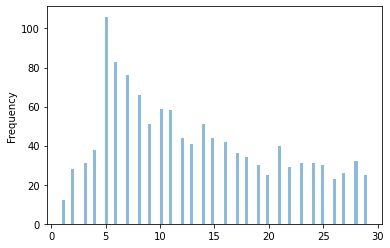

In [130]:
size[size<30].plot.hist(bins=100, alpha=0.5)

In [149]:
toronto_data.to_csv('decreased.csv')

In [144]:
rangs=[5,20,100,300,500,1000,2000,3000]
for i in rangs:
    numToDel=round(i/2)+round(i/3)
    print(numToDel)

4
17
83
250
417
833
1667
2500


In [135]:
rangs[0:5]

[5, 20, 100, 300, 500]

In [129]:
size[size<7]

name
Saaj Baghdad                       1
People's Farmers Market            1
The Lombard Market                 1
Picomart                           1
Suki Hana                          1
                                  ..
Mando's Wings & T'ings             6
Mangiamo!                          6
McCormick Pier Grocery and Deli    6
AfriCafe                           6
Swan Mart                          6
Length: 298, dtype: int64

In [141]:
size[size.index=='Saaj Baghdad'].to_numpy()[0]

1

In [112]:
toronto_data.dropna().shape

(347101, 7)

In [110]:
toronto_data.dropna().shape

(356301, 7)

In [60]:
toronto_data['name'].unique().shape

(3410,)

In [18]:
toronto_data[toronto_data['name']=='Starbucks']

,Unnamed: 0,business_id,user_id,super_score,Keywords,name,categories
628,628,0nMbLN0B5I-2tNnQLSo86w,4cDqW9sWnZ57tsIEiElJWw,5.117199,"place, food, great, love, service, really, wel...",Starbucks,"Bakeries, Coffee & Tea, Food"
629,629,0nMbLN0B5I-2tNnQLSo86w,YTbLG47KGh60ytzoIKuEEQ,4.113346,"place, food, great, love, service, really, wel...",Starbucks,"Bakeries, Coffee & Tea, Food"
630,630,0nMbLN0B5I-2tNnQLSo86w,OnVs0yRSIdpRcLmqh7unIQ,1.377460,"order, time, wait, food, give, table, ask, nev...",Starbucks,"Bakeries, Coffee & Tea, Food"
631,631,0nMbLN0B5I-2tNnQLSo86w,H3dISypkR0q82lcFC6QX0A,1.388611,"place, food, great, love, service, really, wel...",Starbucks,"Bakeries, Coffee & Tea, Food"
632,632,0nMbLN0B5I-2tNnQLSo86w,AbpLSpl4kzCIKZRQOl7G8w,1.030142,"place, food, great, love, service, really, wel...",Starbucks,"Bakeries, Coffee & Tea, Food"
...,...,...,...,...,...,...,...
409149,409149,OFKrWzTdBLFEQwfWlgtL2w,uAL9HaTJHKJVLOaTullgpA,5.301201,"place, food, great, love, service, really, wel...",Starbucks,"Food, Coffee & Tea"
409150,409150,OFKrWzTdBLFEQwfWlgtL2w,1cBUsGNdPFi8n5dzAInxAw,1.198167,"place, food, great, love, service, really, wel...",Starbucks,"Food, Coffee & Tea"
409151,409151,OFKrWzTdBLFEQwfWlgtL2w,R_5NPAhNc_a2HmN2Y3Ga3g,3.114916,"order, chicken, fry, sauce, taste, dish, flavo...",Starbucks,"Food, Coffee & Tea"
409152,409152,OFKrWzTdBLFEQwfWlgtL2w,9rLVMIMltBKV7XMvKaZ0Xg,1.981713,"order, chicken, fry, sauce, taste, dish, flavo...",Starbucks,"Food, Coffee & Tea"


In [61]:
toronto_data.shape

(411424, 7)

In [62]:
toronto_data=toronto_data.dropna().shape

(410701, 7)

In [47]:
toronto_data.groupby('name').size().

name
10 Barrel Brewing Portland    957
108 Bar N Grill                30
10th Avenue Liquor Store       15
11th Avenue Liquor             26
13 Virtues Brewing            107
                             ... 
kBap                            6
krazy cups and cafe             5
red e café                     64
show bar                       14
veggie bowl                    28
Length: 3410, dtype: int64

In [79]:
size[size >1000]

name
Tin Shed Garden Cafe                       1001
Gravy                                      1006
Kizuki Ramen & Izakaya                     1009
Voodoo Doughnut - Davis                    1009
Blue Star Donuts                           1040
Fogo de Chao Brazilian Steakhouse          1120
Starbucks                                  1124
Little Big Burger                          1134
PDX Sliders                                1137
The Observatory                            1154
Petite Provence                            1170
Bollywood Theater                          1219
Marukin Ramen                              1224
Sizzle Pie                                 1256
Killer Burger                              1296
Stumptown Coffee Roasters                  1296
Lechon                                     1342
Por Qué No? Taqueria                       1353
Andina Restaurant                          1473
Cheryl’s on 12th                           1579
Lardo                              

In [70]:
for i in size.index:
    print(i)

Saaj Baghdad
People's Farmers Market
The Lombard Market
Picomart
Suki Hana
Johnson Creek Market
28TH Food Mart
Taqueria el Canario
Sheish Kabob Grill
Portland Pedal Power
Sunny's Mini Mart
North Harbour Cafe
Heavens Tea, School of Tea Arts
Pop & Paint
Cafe Today at the Liberty Centre
Food Villa Market
Mt Tabor Fine Wines
Seattle's Best Coffee
Adam King of Shawarma & Gyro
Caffe Nizza
The Lamb's Table Catering
Panda Cafe
Downtown Grocery
Casablanca Express
Williams Street Market
Jacksons Food Stores #522
Going Street Market
CorksCru Wine Merchants
Go Cart
Metzger Grocery
The Armory Bar
Giusto Farms
MA & PA Market
Recharge Cafe
Spunky Monkey Coffee Roasters
Mock Crest Grocery
OHSU Farmer's Market
Simmer Down Catering
Lloyd Farmers' Market
52nd Avenue Market
Rockwood Liquor Store
Chocolate Craft Studio
Charley's On Grand
Pod Bar
Choi's Kimchi
Cinco De Mayo
Chang Fa Supermarket
Hillsdale Liquor
Portland Brew Bus
Rafati's Catering
Reed College Commons
Asap Market
Balanced By Nature
50th Mark

Extracto Coffeehouse
Gyro Place
Santo Domingo Taqueria
Hammy's Pizza
La Arepa
Backyard Social
Aloha PDX Food Cart
Peter's Bar and Grill
Bison Coffee House
Xport Bar & Lounge
The Old Gold
Joy Teriyaki
El Jalisco
Westward Whiskey
Sextant Bar and Galley
Namaste Bazaar
Sushi Hana
Persian House Restaurant
Fubonn Supermarket
Pho Dalat
The Doghouse Pdx
Namu
Nite Hawk Cafe & Lounge
Tarad Thai
Yang‘s Noodle
Pho Jasmine Restaurant
Vivienne Kitchen & Pantry
China Delight
Crush
Half Pint Cafe
Broadway Grill & Brewery
Dante's
St. Johns Theater & Pub
Home, A Bar
Dairy Queen Grill & Chill
Casa Zoraya
Thai Yummy
Kask
Mandarin Palace
India Grill
JinJu Patisserie
Flying Fish Company
Honey Jar Cafe
Nectar Frozen Yogurt Lounge
Castagna Restaurant
Bake on the Run
Tope
Kenny & Zuke's Delicatessen & Market
Sweet Heart Pizza
Ixtapa Family Mexican Restaurant
Shawarma Express PDX
Spirit of '77
Hit the Spot!
Moon & Sixpence British Pub
PDX Dönerländ
India Oven
Quesabrosa
Old Town Brewing Co
Donuts Plus
808 Grind

In [95]:
(size[size.index=="Screen Door"]>500).to_numpy()[0]

True

In [89]:
for uname in toronto_data['name'].unique():
    print(str(uname))

Marukin Ramen
Starbucks
Tea Chai Te
PDX Sliders
Lechon
Gastro Mania
Urban German Wursthaus
Donut Palace
Fifty Licks
Cha Cha Cha Taqueria
Caspian Kabob
Barista
Miyamoto Sushi
Walgreens
Basilisk
Reo's Ribs
The Whole Bowl
Gartner's Country Meat Market
The Good Earth Cafe
City Thai Portland
QDOBA Mexican Eats
Eb & Bean
Southland Whiskey Kitchen
Kauai Island Grill
Presso Coffee Bar
Montavilla Brew Works
McCormick & Schmick's Harborside at the Marina
Tin Shed Garden Cafe
Bijou Cafe
Red Robin Gourmet Burgers and Brews
Coquine
Pizza Nostra
Juniors Cafe
Pho Oregon Restaurant
Taqueria Rico Taco
Vtopia All Vegan Restaurant & Cheese Shop
Mojo Crepes
Anna's Island Cafe
Sokongdong Tofu & BBQ
Aroy Thai Bistro
Mama Chow's Kitchen
Papa Murphy's
Bread and Ink Cafe
Baby Doll Pizza
Never Coffee
Bridge City Cafe - Lloyd Center
La Taq
Anna Bannanas NW
Swank Restaurant
Ole Frijole
Loving Hut
Expatriate
Poblano Pepper
Ben & Jerry’s
Green Apple Froyo & Bubble T
Yataimura Maru
Dutch Bros Coffee
Shari's - Delta 

Beijing House
Shell
Thai Street Cart
Tammy Kitchen To Go
Sweet Cream Cafe
Portland Wine Storage
Original Joe's
Cullen's Corner
The Landmark Saloon
Western Bikeworks
Taste of Poland
Picasso Pizza
Westward Whiskey
Sam's Cafe
Nova Coffee
Springwater Station
Mashita Teriyaki
MoonBrine
Bagel & Box
Wicked Smart Pizza
Basha's Mediterranean Cuisine
McQueen's  Bar & Grill
Justy's Produce and Flowers
Berry Good Produce
El Torito
Chevron Stations
Riverwalk Cafe
Mixers Bar & Grill
Bull Run Distilling Company
DEN
Rafati's Catering
The 19th Hole
Claudia's Sports Pub
Subway Restaurants
Mo Betta Deli
Russian Elegance Food
Tandoor Indian  Kitchen
Safari Restaurant
Flor de Guelaguetza
Ohana Dessert and Shave Ice
Eurobake
Menlo Park Liquor Store
Capitol Highway Deli Foodmart
Penny Market
Tall Boy
La Puerta Salvadorian cuisine
Braganza Tea
Portland Brew Bus
Sawasdee Thai
Go Cart
Bar 3
Columbia Farms U-Pick
Club SinRock - Portland
Cracker Barrel Grocery
Tik Tok Deli & Lounge
Nourish Northwest
Arthur's Dine

In [ ]:
toronto_data[toronto_data['name']==uname]=toronto_data[toronto_data['name']==uname].drop(toronto_data[toronto_data['name']==uname].index[0:3000])

In [37]:
toronto_data[toronto_data['name']=='Starbucks']

,Unnamed: 0,business_id,user_id,super_score,Keywords,name,categories
629,629.0,0nMbLN0B5I-2tNnQLSo86w,YTbLG47KGh60ytzoIKuEEQ,4.113346,"place, food, great, love, service, really, wel...",Starbucks,"Bakeries, Coffee & Tea, Food"
630,630.0,0nMbLN0B5I-2tNnQLSo86w,OnVs0yRSIdpRcLmqh7unIQ,1.377460,"order, time, wait, food, give, table, ask, nev...",Starbucks,"Bakeries, Coffee & Tea, Food"
631,631.0,0nMbLN0B5I-2tNnQLSo86w,H3dISypkR0q82lcFC6QX0A,1.388611,"place, food, great, love, service, really, wel...",Starbucks,"Bakeries, Coffee & Tea, Food"
632,632.0,0nMbLN0B5I-2tNnQLSo86w,AbpLSpl4kzCIKZRQOl7G8w,1.030142,"place, food, great, love, service, really, wel...",Starbucks,"Bakeries, Coffee & Tea, Food"
633,633.0,0nMbLN0B5I-2tNnQLSo86w,Rm6qd9FsOLOhG-6zvRYeDQ,5.402722,"order, time, wait, food, give, table, ask, nev...",Starbucks,"Bakeries, Coffee & Tea, Food"
...,...,...,...,...,...,...,...
409149,409149.0,OFKrWzTdBLFEQwfWlgtL2w,uAL9HaTJHKJVLOaTullgpA,5.301201,"place, food, great, love, service, really, wel...",Starbucks,"Food, Coffee & Tea"
409150,409150.0,OFKrWzTdBLFEQwfWlgtL2w,1cBUsGNdPFi8n5dzAInxAw,1.198167,"place, food, great, love, service, really, wel...",Starbucks,"Food, Coffee & Tea"
409151,409151.0,OFKrWzTdBLFEQwfWlgtL2w,R_5NPAhNc_a2HmN2Y3Ga3g,3.114916,"order, chicken, fry, sauce, taste, dish, flavo...",Starbucks,"Food, Coffee & Tea"
409152,409152.0,OFKrWzTdBLFEQwfWlgtL2w,9rLVMIMltBKV7XMvKaZ0Xg,1.981713,"order, chicken, fry, sauce, taste, dish, flavo...",Starbucks,"Food, Coffee & Tea"


In [105]:
toronto_data.dropna()['name'].unique().shape

(3410,)

In [40]:
toronto_data.dropna()

,Unnamed: 0,business_id,user_id,super_score,Keywords,name,categories


In [9]:
data=toronto_data
toronto_restaurant_rating = data.pivot_table(index = 'user_id', columns = 'name', values = 'super_score')


MemoryError: Unable to allocate 4.21 GiB for an array with shape (165629, 3410) and data type float64